In [1]:
from pylab import *
import csv
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import minimize

In [2]:
def load_engine_data(file_name):
    """
    Load engine data from a CSV file and filter out non-positive RPM and torque values.

    Parameters:
    file_name (str): Path to the CSV file.

    Returns:
    tuple: Filtered arrays for RPM, torque, power (P), and efficiency.
    """
    # Read the CSV file
    df = pd.read_csv(file_name, sep=';')

    # Extract columns and assign meaningful variable names
    rpm_values = df.iloc[:, 0].values
    torque_values = df.iloc[:, 1].values
    power_values = df.iloc[:, 2].values
    efficiency_values = df.iloc[:, 3].values

    # Filter out entries with non-positive RPM or torque
    valid_indices = np.where((rpm_values > 0) & (torque_values > 0))[0]

    # Apply the filter
    rpm_values = rpm_values[valid_indices]
    torque_values = torque_values[valid_indices]
    power_values = power_values[valid_indices]
    efficiency_values = efficiency_values[valid_indices]

    return rpm_values, torque_values, power_values, efficiency_values


In [3]:
def calculate_T_WOT(rpm_values, torque_values):
    """
    Calculate the CWOT (maximum torque for each unique RPM value).

    Parameters:
    rpm_values (array): Array of RPM values sorted in ascending order.
    torque_values (array): Array of corresponding torque values.

    Returns:
    array: Array where each unique RPM has its maximum torque repeated across its occurrences.
    """
    # Find where the RPM value changes
    rpm_changes = np.diff(rpm_values) > 0
    change_indices = np.where(rpm_changes)[0]

    # Include the last index to capture the final RPM change
    change_indices = np.concatenate((change_indices, [len(rpm_values) - 1]))

    # Calculate the number of repetitions for each RPM
    segment_lengths = np.diff(np.concatenate(([0], change_indices + 1)))

    # Repeat the maximum torque for each unique RPM segment
    torque_wot = np.repeat(torque_values[change_indices], segment_lengths)

    return torque_wot


In [4]:
def calculate_wot_boundary(rpm_value, rpm_values, torque_wot_values):
    """
    Interpolate the WOT boundary torque for a given RPM value.

    Parameters:
    rpm_value (float): The RPM value for which the WOT boundary torque is calculated.
    rpm_values (array): Array of RPM values sorted in ascending order.
    torque_wot_values (array): Array of corresponding WOT torque values.

    Returns:
    float: Interpolated WOT boundary torque value for the given RPM.
    """
    # Find the index where the RPM value would fit in the sorted array
    index = np.searchsorted(rpm_values, rpm_value)

    if index == 0:
        # If the RPM value is less than the smallest RPM, return the first torque value
        return torque_wot_values[0]
    else:
        # Perform linear interpolation between the two closest RPM points
        rpm_lower = rpm_values[index - 1]
        rpm_upper = rpm_values[index]
        torque_lower = torque_wot_values[index - 1]
        torque_upper = torque_wot_values[index]

        interpolated_value = torque_lower + (torque_upper - torque_lower) * (rpm_value - rpm_lower) / (rpm_upper - rpm_lower)
        return interpolated_value


In [5]:
def plot_maps(parameters, torque_wot, rpm_values):
    """
    Plot a contour map based on engine parameters, WOT torque values, and RPM values.

    Parameters:
    parameters (tuple): Engine parameters (n_i, alpha, epsilon, betha).
    torque_wot (array): Array of WOT torque values.
    rpm_values (array): Array of RPM values in ascending order.
    """
    # Generate an RPM range and corresponding angular velocity
    rpm_range = np.arange(rpm_values[0], np.max(rpm_values), 20)
    angular_velocity = rpm_range * 2 * np.pi / 60

    # Generate torque values for the grid
    torque_range = np.linspace(-np.abs(np.max(torque_wot)) - 10, np.abs(np.max(torque_wot)) + 10, len(rpm_range))

    # Create the meshgrid for RPM and torque
    RPM_grid, torque_grid = np.meshgrid(rpm_range, torque_range)
    angular_velocity_grid = RPM_grid * 2 * np.pi / 60

    # Calculate WOT boundary values for each RPM and reshape to match the grid
    wot_boundary_values = np.array([calculate_wot_boundary(rpm, rpm_values, torque_wot) for rpm in rpm_range])
    wot_boundary_grid = np.tile(wot_boundary_values, (len(torque_range), 1))

    # Extract engine parameters
    n_i, alpha, epsilon, betha = parameters

    # Calculate power output
    power_output = (torque_grid * angular_velocity_grid / n_i +
                    alpha * angular_velocity_grid / n_i +
                    epsilon * (torque_grid ** 2) / n_i +
                    betha / n_i) / 1000

    # Apply boundary conditions (nullify values outside the WOT boundaries)
    power_output[np.abs(torque_grid) > wot_boundary_grid] = -1000

    # Define contour levels
    contour_levels = np.array([-150, -100, -70, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 70, 100, 150])
    contour_labels = contour_levels[1:]

    # Plot contour map
    contour_lines = plt.contour(RPM_grid, torque_grid, power_output, levels=contour_levels, colors='k')
    plt.clabel(contour_lines, levels=contour_labels, inline=True, fontsize=12)

    # Plot filled contours
    plt.contourf(RPM_grid, torque_grid, power_output, levels=contour_levels, cmap='Spectral')
    plt.colorbar(label='Power Output (kW)')

    # Add labels and title
    plt.xlabel('Engine Speed (RPM)')
    plt.ylabel('Torque (Nm)')
    plt.title('Engine Performance Contour Map')

    # Show the plot
    plt.show()


In [6]:
def optimize_engine_parameters(file_name, print_maps=False):
    """
    Optimize engine parameters based on input data and optionally plot performance maps.

    Parameters:
    file_name (str): Path to the input file containing engine data.
    print_maps (bool): Whether to generate and display performance maps.

    Returns:
    list: Optimized parameters and key results.
    """
    # Load engine data
    rpm, torque, power_values, efficiency = load_engine_data(file_name)

    # Calculate angular velocity
    angular_velocity = rpm * 2 * np.pi / 60

    # Prepare variables
    torque_wot = calculate_T_WOT(rpm, torque)
    max_power = np.max(power_values) * 1000

    # Define the optimization objective function
    def objective_function(parameters):
        n_i, alpha, epsilon, betha = parameters
        power_model = (torque * angular_velocity / n_i +
                       alpha * angular_velocity / n_i * 10 +
                       epsilon * (torque ** 2) / n_i +
                       betha / n_i * 100) / 1000
        error = np.abs((power_values - power_model) / power_values * 100)
        return np.sum(error)

    # Initial parameters and bounds
    initial_params = [np.max(efficiency) / 100, 1, 1, 1]
    parameter_bounds = [(np.max(efficiency) / 100, 1), (0, 5), (0, 5), (0, 5)]

    # Perform optimization
    optimization_result = minimize(objective_function, initial_params, method='Powell', bounds=parameter_bounds)

    # Extract optimized parameters and calculate error
    optimal_params = optimization_result.x
    mean_error = objective_function(optimal_params) / len(rpm)

    # Apply scaling to optimal parameters
    optimal_params = optimal_params * (1, 10, 1, 100)
    optimal_params = list(optimal_params)

    # Prepare results to return
    results = [np.max(efficiency), max_power] + optimal_params + [mean_error]

    if print_maps:
        # Recalculate power model and error for visualization
        n_i, alpha, epsilon, betha = optimal_params
        power_model = (torque * angular_velocity / n_i +
                       alpha * angular_velocity / n_i +
                       epsilon * (torque ** 2) / n_i +
                       betha / n_i) / 1000
        error_distribution = (power_model - power_values) / power_values * 100

        # Plot performance maps
        plot_maps(optimal_params, torque_wot, rpm)

        # Plot scatter plot of RPM vs torque with color-coded error
        max_error = np.max(np.abs(error_distribution))

        cmap = LinearSegmentedColormap.from_list(
            'custom_cmap', [(0, 'darkred'), (0.25, 'orange'), (0.5, 'white'), (0.75, 'dodgerblue'), (1, 'darkblue')]
        )

        plt.scatter(rpm, torque, c=error_distribution, cmap=cmap, s=100, vmin=-max_error, vmax=max_error,edgecolor='black')
        plt.colorbar(label='Relative Error (%)')
        plt.xlabel('Engine Speed (RPM)')
        plt.ylabel('Torque (Nm)')
        plt.title('Relative Error Map')
        plt.show()

    return results


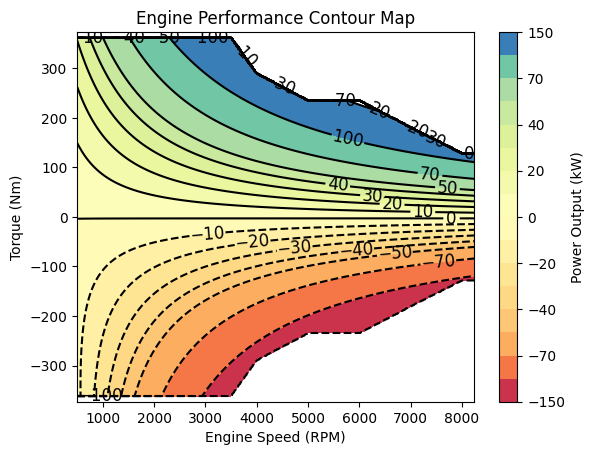

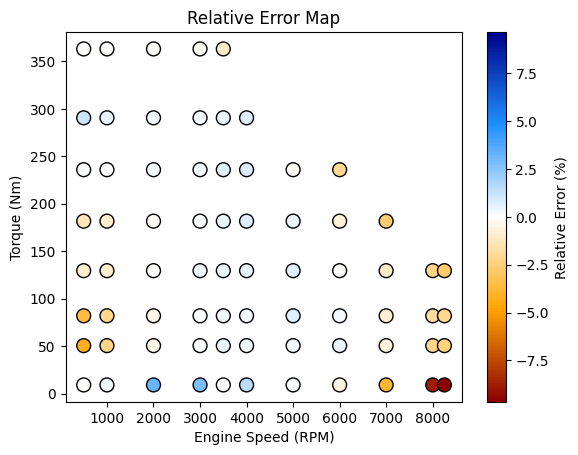

[95.6,
 159680.0,
 0.9904115311908701,
 2.8599723473884535,
 0.08588933424782157,
 39.06522416681767,
 1.153649276783167]

In [7]:
optimize_engine_parameters('C150_EV.csv',True)

In [8]:
# Read the list of engine files
df = pd.read_csv('list_engine.csv', sep=';')
engine_names = df.iloc[:, 0].values

# Initialize results list
results = []

# Loop through each engine and perform optimization
for engine_name in engine_names:
    file_name = engine_name + ".csv"
    results.append(optimize_engine_parameters(file_name))

# Define column names for the results DataFrame
columns = ['max_eff', 'Pmax', 'n_i', 'alpha', 'epsilon', 'betha', 'ecart']

# Create a DataFrame from the results
summary = pd.DataFrame(results, index=engine_names, columns=columns)

# Generate a timestamp for the file name
results_file_name = 'elec_results.csv'

# Save the results to a CSV file
summary.to_csv(results_file_name)

print('End')

End
